In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from glob import glob
import os

from sklearn.preprocessing import StandardScaler

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm
from sklearn import metrics
from sklearn import model_selection as ms
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from rerf.rerfClassifier import rerfClassifier
from sklearn.model_selection import cross_validate

import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import average_precision_score

In [2]:
def prepare_data_train(fname_d,fname_e):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname_d)
    # events file
    #events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(fname_e)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels


def prepare_data_test(fname):
    """ read and prepare test data """
    # Read data
    data = pd.read_csv(fname)
    return data

scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
def data_preprocess_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep

In [3]:
##downsamplig naive like this is not correct, if you do not low pass filter.
##this down sampling here it needed only to keep the script run below 10 minutes.
## please do not downsample or use correct procedure to decimate data without alias
subsample=100 # training subsample.if you want to downsample the training data
#######columns name for labels#############
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']




#######number of subjects###############
subjects = range(1,9)
ids_tot = []
pred_tot = []
X = []
Y = []
###loop on subjects and 8 series for train data + 2 series for test data
for subject in subjects:
    y_raw= []
    raw = []
    ################ READ DATA ################################################
    for i in range(4,7):
        fname_d =  '/media/ubuntu/DATA/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_data.csv' % (i)
        fname_e =  '/media/ubuntu/DATA/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_events.csv' % (i)
        data,labels=prepare_data_train(fname_d,fname_e)
        raw.append(data)
        y_raw.append(labels)
        

    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #print (length(X))
    #print (length(y))
    #transform in numpy array
    #transform train data in numpy array
    X_train =np.asarray(X.astype(float))
    Y_train = np.asarray(y.astype(float))
    

    
######Preparing test data#####################
subjects = range(11,12)
ids_tot = []
pred_tot = []
X_t = []
y_t = []
###loop on subjects and 8 series for train data + 2 series for test data
for subject in subjects:
    y_raw_t= []
    raw_t = []
    ################ READ DATA ################################################
    for i in range(1,3):
        fname_d =  '/media/ubuntu/DATA/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_data.csv' % (i)
        fname_e =  '/media/ubuntu/DATA/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_events.csv' % (i)
        dt,lb=prepare_data_train(fname_d,fname_e)
        raw_t.append(dt)
        y_raw_t.append(lb)
        

    X_t = pd.concat(raw_t)
    y_t = pd.concat(y_raw_t)
    #print (length(X))
    #print (length(y))
    #transform in numpy array
    #transform train data in numpy array
    X_test =np.asarray(X_t.astype(float))
    Y_test = np.asarray(y_t.astype(float))

In [4]:
train_dat = X.join(y.iloc[:,1])
not_act = train_dat[train_dat.iloc[:,32]==0]
act = train_dat[train_dat.iloc[:,32]==1]
#print (len(not_act))
not_act_downsampled = resample(not_act,
                                replace = False, # sample without replacement
                                
                               n_samples = 2*len(act), # match minority n
                                random_state = 27) # reproducible results
#print(len(not_act_downsampled))
X_train_downsampled = pd.concat([not_act_downsampled,act])
Y_train_downsampled = X_train_downsampled.iloc[:,32]
X_train_downsampled.drop(X_train_downsampled.columns[[32]],axis=1,inplace = True)
#print(X_train_downsampled)
print(len(X_train_downsampled))
print(len(Y_train_downsampled))

test_dat = X_t.join(y_t.iloc[:,1])
not_act_t = test_dat[test_dat.iloc[:,32]==0]
act_t = test_dat[test_dat.iloc[:,32]==1]
not_act_downsampled_t = resample(not_act_t,
                                replace = False, # sample without replacement
                                n_samples = 2*len(act_t), # match minority n
                                random_state = 27) # reproducible results
#print(len(not_act_downsampled_t))
X_test_downsampled = pd.concat([not_act_downsampled_t,act_t])
Y_test_downsampled = X_test_downsampled.iloc[:,32]
X_test_downsampled.drop(X_test_downsampled.columns[[32]],axis=1,inplace = True)
#print(X_train_downsampled)
print(len(X_test_downsampled))
print(len(Y_test_downsampled))

113850
113850
51300
51300


In [5]:
from sklearn.model_selection import train_test_split

#X_train, X_rem, Y_train, Y_rem = train_test_split(X_train,Y_train,test_size=0.6,random_state =0)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train_downsampled)
X_test = sc.fit_transform(X_test_downsampled)


X_train =np.asarray(X_train.astype(float))
Y_train = np.asarray(Y_train_downsampled.astype(float))

X_test =np.asarray(X_test.astype(float))
Y_test = np.asarray(Y_test_downsampled.astype(float))

print(len(X_test))
print(len(X_train))

51300
113850


In [6]:
%reset_selective -f raw#,y_raw,raw_t,y_rar_t
raw,y_raw,raw_t,y_rar_t = None,None,None,None
#import os
#import psutil
#process = psutil.Process(os.getpid())
#print(process.memory_info().rss)  # in bytes 
print (raw)

None


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

10
0




 57%|█████▋    | 4/7 [00:00<00:00,  6.24it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.39it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.94it/s]

100%|██████████| 7/7 [00:01<00:00,  6.70it/s]

 20%|██        | 1/5 [00:01<00:04,  1.08s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

1




 57%|█████▋    | 4/7 [00:00<00:00,  5.89it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.19it/s]

100%|██████████| 7/7 [00:01<00:00,  6.52it/s]

 40%|████      | 2/5 [00:02<00:03,  1.09s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

2




 57%|█████▋    | 4/7 [00:00<00:00,  6.24it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.45it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  7.16it/s]

100%|██████████| 7/7 [00:01<00:00,  6.66it/s]

 60%|██████    | 3/5 [00:03<00:02,  1.09s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

3




 57%|█████▋    | 4/7 [00:00<00:00,  6.74it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.69it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  7.42it/s]

100%|██████████| 7/7 [00:01<00:00,  6.99it/s]

 80%|████████  | 4/5 [00:04<00:01,  1.07s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

4




 57%|█████▋    | 4/7 [00:00<00:00,  6.20it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.29it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.90it/s]

100%|██████████| 7/7 [00:01<00:00,  6.64it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

100
0




 43%|████▎     | 3/7 [00:00<00:00, 13.48it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.58it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.78it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.30it/s]

100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

 20%|██        | 1/5 [00:01<00:07,  2.00s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

1




 43%|████▎     | 3/7 [00:00<00:00, 13.27it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.55it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.75it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.78it/s]

100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

 40%|████      | 2/5 [00:04<00:06,  2.06s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

2




 43%|████▎     | 3/7 [00:00<00:00, 14.04it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.41it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.61it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.23it/s]

100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

 60%|██████    | 3/5 [00:06<00:04,  2.05s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

3




 43%|████▎     | 3/7 [00:00<00:00, 13.62it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.34it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.51it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.94it/s]

100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

 80%|████████  | 4/5 [00:08<00:02,  2.09s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

4




 43%|████▎     | 3/7 [00:00<00:00, 14.65it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.58it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.81it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.48it/s]

100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

1000
0




 29%|██▊       | 2/7 [00:00<00:00, 10.81it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.84it/s]

 57%|█████▋    | 4/7 [00:02<00:02,  1.31it/s]

 71%|███████▏  | 5/7 [00:03<00:01,  1.47it/s]

 86%|████████▌ | 6/7 [00:14<00:03,  3.71s/it]

100%|██████████| 7/7 [00:17<00:00,  2.57s/it]

 20%|██        | 1/5 [00:18<01:12, 18.02s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 13.10it/s]

1




 43%|████▎     | 3/7 [00:01<00:01,  2.52it/s]

 57%|█████▋    | 4/7 [00:03<00:02,  1.24it/s]

 71%|███████▏  | 5/7 [00:03<00:01,  1.42it/s]

 86%|████████▌ | 6/7 [00:14<00:03,  3.75s/it]

100%|██████████| 7/7 [00:18<00:00,  2.58s/it]

 40%|████      | 2/5 [00:36<00:54, 18.05s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

2




 29%|██▊       | 2/7 [00:00<00:00,  9.50it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.42it/s]

 57%|█████▋    | 4/7 [00:03<00:02,  1.25it/s]

 71%|███████▏  | 5/7 [00:03<00:01,  1.42it/s]

 86%|████████▌ | 6/7 [00:14<00:03,  3.79s/it]

100%|██████████| 7/7 [00:18<00:00,  2.64s/it]

 60%|██████    | 3/5 [00:54<00:36, 18.18s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

3




 29%|██▊       | 2/7 [00:00<00:00,  9.67it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.46it/s]

 57%|█████▋    | 4/7 [00:03<00:02,  1.24it/s]

 71%|███████▏  | 5/7 [00:03<00:01,  1.40it/s]

 86%|████████▌ | 6/7 [00:14<00:03,  3.66s/it]

100%|██████████| 7/7 [00:18<00:00,  2.59s/it]

 80%|████████  | 4/5 [01:12<00:18, 18.18s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 10.18it/s]

4




 43%|████▎     | 3/7 [00:01<00:01,  2.60it/s]

 57%|█████▋    | 4/7 [00:02<00:02,  1.27it/s]

 71%|███████▏  | 5/7 [00:03<00:01,  1.45it/s]

 86%|████████▌ | 6/7 [00:16<00:04,  4.34s/it]

100%|██████████| 7/7 [00:19<00:00,  2.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

2500
0




 29%|██▊       | 2/7 [00:00<00:01,  4.45it/s]

 43%|████▎     | 3/7 [00:03<00:04,  1.05s/it]

 57%|█████▋    | 4/7 [00:07<00:05,  1.90s/it]

 71%|███████▏  | 5/7 [00:08<00:03,  1.60s/it]

 86%|████████▌ | 6/7 [00:30<00:07,  7.70s/it]

100%|██████████| 7/7 [00:40<00:00,  5.85s/it]

 20%|██        | 1/5 [00:40<02:43, 40.97s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

1




 29%|██▊       | 2/7 [00:00<00:01,  4.84it/s]

 43%|████▎     | 3/7 [00:02<00:03,  1.09it/s]

 57%|█████▋    | 4/7 [00:06<00:04,  1.63s/it]

 71%|███████▏  | 5/7 [00:07<00:02,  1.41s/it]

 86%|████████▌ | 6/7 [00:30<00:07,  7.84s/it]

100%|██████████| 7/7 [00:40<00:00,  5.74s/it]

 40%|████      | 2/5 [01:21<02:02, 40.73s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

2




 29%|██▊       | 2/7 [00:00<00:00,  5.25it/s]

 43%|████▎     | 3/7 [00:02<00:03,  1.18it/s]

 57%|█████▋    | 4/7 [00:06<00:04,  1.58s/it]

 71%|███████▏  | 5/7 [00:06<00:02,  1.38s/it]

 86%|████████▌ | 6/7 [00:33<00:09,  9.01s/it]

100%|██████████| 7/7 [00:43<00:00,  6.22s/it]

 60%|██████    | 3/5 [02:04<01:23, 41.59s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

3




 29%|██▊       | 2/7 [00:00<00:00,  5.24it/s]

 43%|████▎     | 3/7 [00:02<00:03,  1.15it/s]

 57%|█████▋    | 4/7 [00:06<00:05,  1.80s/it]

 71%|███████▏  | 5/7 [00:07<00:03,  1.53s/it]

 86%|████████▌ | 6/7 [00:28<00:07,  7.19s/it]

100%|██████████| 7/7 [00:38<00:00,  5.50s/it]

 80%|████████  | 4/5 [02:43<00:40, 40.68s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

4




 29%|██▊       | 2/7 [00:00<00:00,  5.30it/s]

 43%|████▎     | 3/7 [00:02<00:03,  1.14it/s]

 57%|█████▋    | 4/7 [00:06<00:04,  1.62s/it]

 71%|███████▏  | 5/7 [00:07<00:02,  1.40s/it]

 86%|████████▌ | 6/7 [00:26<00:06,  6.85s/it]

100%|██████████| 7/7 [00:35<00:00,  5.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

5000
0




 29%|██▊       | 2/7 [00:00<00:01,  3.05it/s]

 43%|████▎     | 3/7 [00:05<00:07,  1.76s/it]

 57%|█████▋    | 4/7 [00:12<00:09,  3.22s/it]

 71%|███████▏  | 5/7 [00:14<00:05,  2.76s/it]

 86%|████████▌ | 6/7 [00:49<00:12, 12.62s/it]

100%|██████████| 7/7 [01:11<00:00, 10.15s/it]

 20%|██        | 1/5 [01:11<04:44, 71.09s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

1




 29%|██▊       | 2/7 [00:00<00:01,  2.93it/s]

 43%|████▎     | 3/7 [00:06<00:08,  2.11s/it]

 57%|█████▋    | 4/7 [00:13<00:09,  3.32s/it]

 71%|███████▏  | 5/7 [00:14<00:05,  2.87s/it]

 86%|████████▌ | 6/7 [00:54<00:13, 13.99s/it]

100%|██████████| 7/7 [01:15<00:00, 10.82s/it]

 40%|████      | 2/5 [02:26<03:37, 72.49s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

2




 29%|██▊       | 2/7 [00:00<00:01,  3.09it/s]

 43%|████▎     | 3/7 [00:05<00:06,  1.73s/it]

 57%|█████▋    | 4/7 [00:11<00:09,  3.05s/it]

 71%|███████▏  | 5/7 [00:13<00:05,  2.62s/it]

 86%|████████▌ | 6/7 [00:54<00:14, 14.22s/it]

100%|██████████| 7/7 [01:15<00:00, 10.83s/it]

 60%|██████    | 3/5 [03:42<02:26, 73.49s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

3




 29%|██▊       | 2/7 [00:00<00:01,  3.03it/s]

 43%|████▎     | 3/7 [00:05<00:07,  1.79s/it]

 57%|█████▋    | 4/7 [00:12<00:09,  3.11s/it]

 71%|███████▏  | 5/7 [00:13<00:05,  2.68s/it]

 86%|████████▌ | 6/7 [00:44<00:11, 11.09s/it]

100%|██████████| 7/7 [01:04<00:00,  9.23s/it]

 80%|████████  | 4/5 [04:47<01:10, 70.85s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

4




 29%|██▊       | 2/7 [00:00<00:01,  3.07it/s]

 43%|████▎     | 3/7 [00:05<00:07,  1.78s/it]

 57%|█████▋    | 4/7 [00:11<00:09,  3.08s/it]

 71%|███████▏  | 5/7 [00:13<00:05,  2.66s/it]

 86%|████████▌ | 6/7 [00:55<00:14, 14.32s/it]

100%|██████████| 7/7 [01:15<00:00, 10.85s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

10000
0




 29%|██▊       | 2/7 [00:01<00:03,  1.35it/s]

 43%|████▎     | 3/7 [00:13<00:16,  4.01s/it]

 57%|█████▋    | 4/7 [00:25<00:19,  6.38s/it]

 71%|███████▏  | 5/7 [00:28<00:10,  5.42s/it]

 86%|████████▌ | 6/7 [01:25<00:20, 20.92s/it]

100%|██████████| 7/7 [02:07<00:00, 18.23s/it]

 20%|██        | 1/5 [02:07<08:30, 127.65s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

1




 29%|██▊       | 2/7 [00:01<00:03,  1.65it/s]

 43%|████▎     | 3/7 [00:12<00:15,  3.88s/it]

 57%|█████▋    | 4/7 [00:24<00:18,  6.13s/it]

 71%|███████▏  | 5/7 [00:27<00:10,  5.23s/it]

 86%|████████▌ | 6/7 [01:13<00:17, 17.48s/it]

100%|██████████| 7/7 [01:58<00:00, 16.97s/it]

 40%|████      | 2/5 [04:06<06:15, 125.00s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

2




 29%|██▊       | 2/7 [00:01<00:03,  1.66it/s]

 43%|████▎     | 3/7 [00:12<00:15,  3.90s/it]

 57%|█████▋    | 4/7 [00:24<00:18,  6.17s/it]

 71%|███████▏  | 5/7 [00:27<00:10,  5.27s/it]

 86%|████████▌ | 6/7 [01:29<00:22, 22.30s/it]

100%|██████████| 7/7 [02:16<00:00, 19.51s/it]

 60%|██████    | 3/5 [06:23<04:16, 128.49s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

3




 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]

 43%|████▎     | 3/7 [00:15<00:18,  4.59s/it]

 57%|█████▋    | 4/7 [00:27<00:20,  6.98s/it]

 71%|███████▏  | 5/7 [00:30<00:11,  5.82s/it]

 86%|████████▌ | 6/7 [01:30<00:22, 22.05s/it]

100%|██████████| 7/7 [02:13<00:00, 19.09s/it]

 80%|████████  | 4/5 [08:36<02:10, 130.03s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

4




 29%|██▊       | 2/7 [00:01<00:03,  1.65it/s]

 43%|████▎     | 3/7 [00:12<00:15,  3.93s/it]

 57%|█████▋    | 4/7 [00:25<00:19,  6.60s/it]

 71%|███████▏  | 5/7 [00:28<00:11,  5.57s/it]

 86%|████████▌ | 6/7 [01:24<00:20, 20.56s/it]

100%|██████████| 7/7 [02:09<00:00, 18.55s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

15000
0




 29%|██▊       | 2/7 [00:02<00:05,  1.07s/it]

 43%|████▎     | 3/7 [00:24<00:29,  7.41s/it]

 57%|█████▋    | 4/7 [00:39<00:28,  9.66s/it]

 71%|███████▏  | 5/7 [00:43<00:16,  8.15s/it]

 86%|████████▌ | 6/7 [01:51<00:25, 25.87s/it]

100%|██████████| 7/7 [02:58<00:00, 25.53s/it]

 20%|██        | 1/5 [02:58<11:54, 178.71s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

1




 29%|██▊       | 2/7 [00:02<00:05,  1.05s/it]

 43%|████▎     | 3/7 [00:22<00:27,  6.86s/it]

 57%|█████▋    | 4/7 [00:37<00:28,  9.38s/it]

 71%|███████▏  | 5/7 [00:42<00:15,  7.97s/it]

 86%|████████▌ | 6/7 [01:44<00:24, 24.09s/it]

100%|██████████| 7/7 [02:52<00:00, 24.60s/it]

 40%|████      | 2/5 [05:50<08:50, 176.76s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

2




 29%|██▊       | 2/7 [00:02<00:05,  1.09s/it]

 43%|████▎     | 3/7 [00:22<00:26,  6.74s/it]

 57%|█████▋    | 4/7 [00:36<00:27,  9.17s/it]

 71%|███████▏  | 5/7 [00:41<00:15,  7.82s/it]

 86%|████████▌ | 6/7 [02:00<00:29, 29.15s/it]

100%|██████████| 7/7 [03:08<00:00, 26.95s/it]

 60%|██████    | 3/5 [08:59<06:00, 180.34s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

3




 29%|██▊       | 2/7 [00:02<00:06,  1.31s/it]

 43%|████▎     | 3/7 [00:23<00:29,  7.29s/it]

 57%|█████▋    | 4/7 [00:38<00:28,  9.53s/it]

 71%|███████▏  | 5/7 [00:43<00:16,  8.11s/it]

 86%|████████▌ | 6/7 [01:29<00:19, 19.59s/it]

100%|██████████| 7/7 [02:35<00:00, 22.17s/it]

 80%|████████  | 4/5 [11:34<02:52, 172.81s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

4




 29%|██▊       | 2/7 [00:02<00:05,  1.06s/it]

 43%|████▎     | 3/7 [00:23<00:28,  7.10s/it]

 57%|█████▋    | 4/7 [00:38<00:28,  9.44s/it]

 71%|███████▏  | 5/7 [00:42<00:16,  8.02s/it]

 86%|████████▌ | 6/7 [01:56<00:27, 27.63s/it]

100%|██████████| 7/7 [03:05<00:00, 26.51s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:00,  7.56it/s]

25000
0




 29%|██▊       | 2/7 [00:04<00:07,  1.41s/it]

 43%|████▎     | 3/7 [00:45<00:53, 13.40s/it]

 57%|█████▋    | 4/7 [01:11<00:51, 17.00s/it]

 71%|███████▏  | 5/7 [01:19<00:28, 14.25s/it]

 86%|████████▌ | 6/7 [02:28<00:30, 30.64s/it]

100%|██████████| 7/7 [04:25<00:00, 37.89s/it]

 20%|██        | 1/5 [04:25<17:41, 265.25s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:00,  7.69it/s]

1




 29%|██▊       | 2/7 [00:04<00:07,  1.40s/it]

 43%|████▎     | 3/7 [00:46<00:54, 13.69s/it]

 57%|█████▋    | 4/7 [01:12<00:51, 17.31s/it]

 71%|███████▏  | 5/7 [01:20<00:29, 14.51s/it]

 86%|████████▌ | 6/7 [02:19<00:27, 27.92s/it]

100%|██████████| 7/7 [04:21<00:00, 37.32s/it]

 40%|████      | 2/5 [08:46<13:12, 264.05s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:00,  7.62it/s]

2




 29%|██▊       | 2/7 [00:04<00:07,  1.41s/it]

 43%|████▎     | 3/7 [00:47<00:55, 13.83s/it]

 57%|█████▋    | 4/7 [01:12<00:52, 17.37s/it]

 71%|███████▏  | 5/7 [01:20<00:29, 14.52s/it]

 86%|████████▌ | 6/7 [02:44<00:35, 35.20s/it]

100%|██████████| 7/7 [04:41<00:00, 40.26s/it]

 60%|██████    | 3/5 [13:28<08:58, 269.39s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:00,  7.77it/s]

3




 29%|██▊       | 2/7 [00:04<00:07,  1.40s/it]

 43%|████▎     | 3/7 [00:46<00:54, 13.69s/it]

 57%|█████▋    | 4/7 [01:14<00:54, 18.00s/it]

 71%|███████▏  | 5/7 [01:22<00:29, 14.95s/it]

 86%|████████▌ | 6/7 [02:39<00:33, 33.48s/it]

100%|██████████| 7/7 [04:37<00:00, 39.68s/it]

 80%|████████  | 4/5 [18:06<04:31, 271.91s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:00<00:00,  7.63it/s]

4




 29%|██▊       | 2/7 [00:04<00:07,  1.40s/it]

 43%|████▎     | 3/7 [00:45<00:53, 13.36s/it]

 57%|█████▋    | 4/7 [01:11<00:51, 17.02s/it]

 71%|███████▏  | 5/7 [01:19<00:28, 14.44s/it]

 86%|████████▌ | 6/7 [03:01<00:40, 40.73s/it]

100%|██████████| 7/7 [04:56<00:00, 42.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

50000
0




 14%|█▍        | 1/7 [00:00<00:01,  3.51it/s]

 29%|██▊       | 2/7 [00:10<00:16,  3.37s/it]

 43%|████▎     | 3/7 [02:58<03:30, 52.51s/it]

 57%|█████▋    | 4/7 [04:39<03:21, 67.11s/it]

 71%|███████▏  | 5/7 [04:54<01:43, 51.61s/it]

 86%|████████▌ | 6/7 [06:56<01:12, 72.60s/it]

100%|██████████| 7/7 [11:12<00:00, 96.12s/it] 

 20%|██        | 1/5 [11:12<44:51, 672.85s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

1




 14%|█▍        | 1/7 [00:00<00:01,  3.30it/s]

 29%|██▊       | 2/7 [00:10<00:17,  3.42s/it]

 43%|████▎     | 3/7 [02:52<03:23, 50.81s/it]

 57%|█████▋    | 4/7 [04:33<03:17, 65.75s/it]

 71%|███████▏  | 5/7 [04:48<01:41, 50.77s/it]

 86%|████████▌ | 6/7 [07:40<01:27, 87.08s/it]

100%|██████████| 7/7 [12:00<00:00, 102.88s/it]

 40%|████      | 2/5 [23:13<34:21, 687.05s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

2




 14%|█▍        | 1/7 [00:00<00:01,  3.16it/s]

 29%|██▊       | 2/7 [00:10<00:16,  3.29s/it]

 43%|████▎     | 3/7 [02:54<03:26, 51.58s/it]

 57%|█████▋    | 4/7 [04:37<03:21, 67.05s/it]

 71%|███████▏  | 5/7 [04:54<01:43, 51.76s/it]

 86%|████████▌ | 6/7 [06:48<01:10, 70.52s/it]

100%|██████████| 7/7 [11:11<00:00, 95.98s/it] 

 60%|██████    | 3/5 [34:24<22:45, 682.50s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

3




 14%|█▍        | 1/7 [00:00<00:01,  3.25it/s]

 29%|██▊       | 2/7 [00:10<00:17,  3.42s/it]

 43%|████▎     | 3/7 [03:04<03:37, 54.37s/it]

 57%|█████▋    | 4/7 [04:49<03:29, 69.73s/it]

 71%|███████▏  | 5/7 [05:05<01:47, 53.63s/it]

 86%|████████▌ | 6/7 [08:27<01:37, 97.99s/it]

100%|██████████| 7/7 [12:57<00:00, 111.07s/it]

 80%|████████  | 4/5 [47:22<11:51, 711.02s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

4




 14%|█▍        | 1/7 [00:00<00:01,  3.45it/s]

 29%|██▊       | 2/7 [00:11<00:17,  3.58s/it]

 43%|████▎     | 3/7 [02:57<03:29, 52.41s/it]

 57%|█████▋    | 4/7 [04:43<03:24, 68.22s/it]

 71%|███████▏  | 5/7 [04:58<01:44, 52.49s/it]

 86%|████████▌ | 6/7 [07:38<01:24, 84.61s/it]

100%|██████████| 7/7 [11:58<00:00, 102.68s/it]

100%|██████████| 9/9 [1:59:01<00:00, 793.51s/it] 


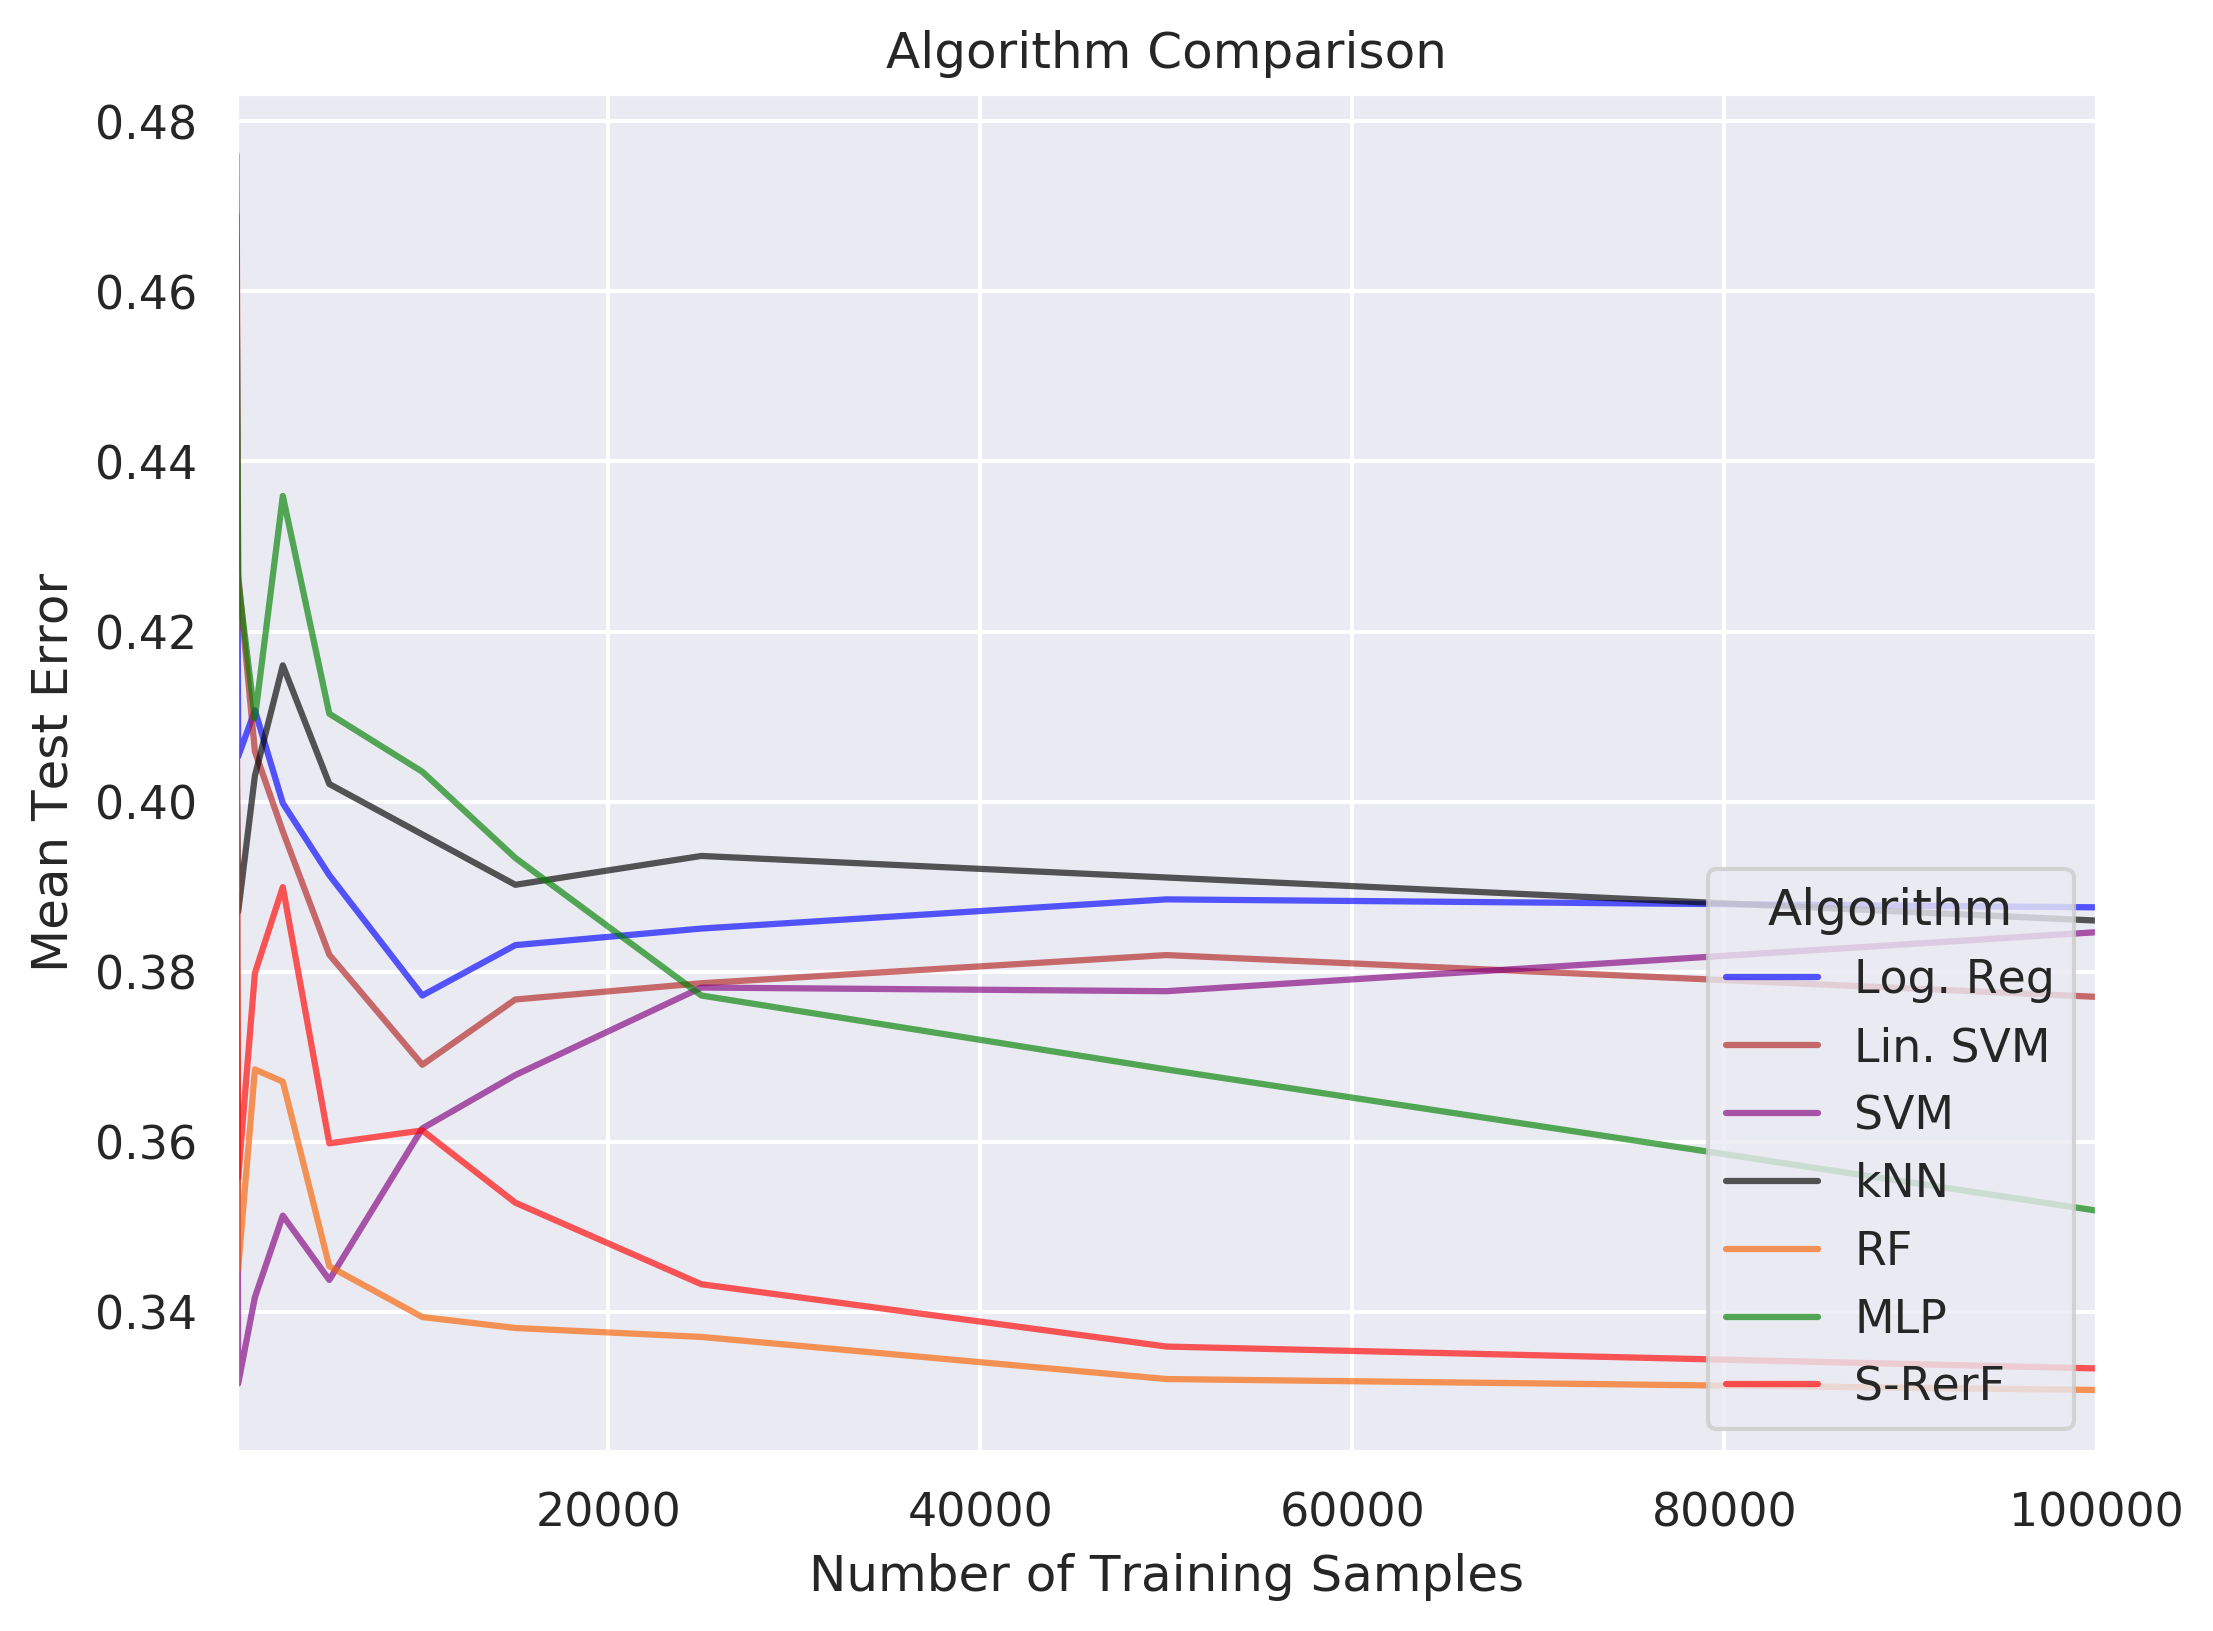

In [8]:
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
          "kNN": "black", "RF":"#f86000", "MLP":"green", "S-RerF":"red"}

ncores=1
num_runs=5
n_est=100

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features=40,
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=1,
                    image_width=32,
                    patch_height_max=1,
                    patch_height_min=1,
                    patch_width_max=10,
                    patch_width_min=1
                   )
    ]

# Train each classifier on each data set size, then test
## Prep output file:
f = open('eeg_grasp_pre_lhat_3.csv', 'w+')
f.write("classifier,n,Lhat,Precision,trainTime,testTime,iterate\n")
f.flush()

#ns = np.array([50,100,200,400,1000,2000])
ns = np.array([10,100,1000,2500,5000,10000,15000,25000,50000])
#runList = [(n, clf, run) for n in ns\
 #          for clf in zip(classifiers, [key for key in names])\
 #          for run in range(num_runs)]
runList = [(clf) for clf in zip(classifiers, [key for key in names])]#\
           #for run in range(num_runs)]
for n in tqdm(ns):
    print (n)
    for iteration in tqdm(range(num_runs)):
        
        X_train1, X_rem, Y_train1, Y_rem = train_test_split(X_train,Y_train,test_size=0.5)
        X_test1, X_rem, Y_test1, Y_rem = train_test_split(X_test,Y_test,test_size=0.5)
        
        X_rem,Y_rem = None,None;
        
        X = X_train1[:n]
        y = Y_train1[:n]
        print (iteration)
        for clf in tqdm(runList):
            
            trainStartTime = time.time()
            clf[0].fit(X, y)
            trainEndTime = time.time()
            trainTime = trainEndTime - trainStartTime

           # scoring = ['precision_macro', 'recall_macro']
            #crossvalStartTime = time.time()
            #scores = ms.cross_val_score(clf[0], X, y, cv=2)
            #av_score = np.mean(scores)
            #crossvalEndTime = time.time()
            #crossvalTime = crossvalEndTime - crossvalStartTime

            #X,y,scores = None,None,None

            testStartTime = time.time()
            out = clf[0].predict(X_test1)
            testEndTime = time.time()
            testTime = testEndTime - testStartTime

            lhat = np.mean(np.not_equal(out, Y_test1).astype(int))
            avg_precision = average_precision_score(out, Y_test1)


            ####("variable,Lhat,trainTime,testTime,iterate")
            f.write(f"{clf[1]}, {n}, {lhat:2.9f},{avg_precision:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
            f.flush()
            # {av_score:2.9f},
f.close()


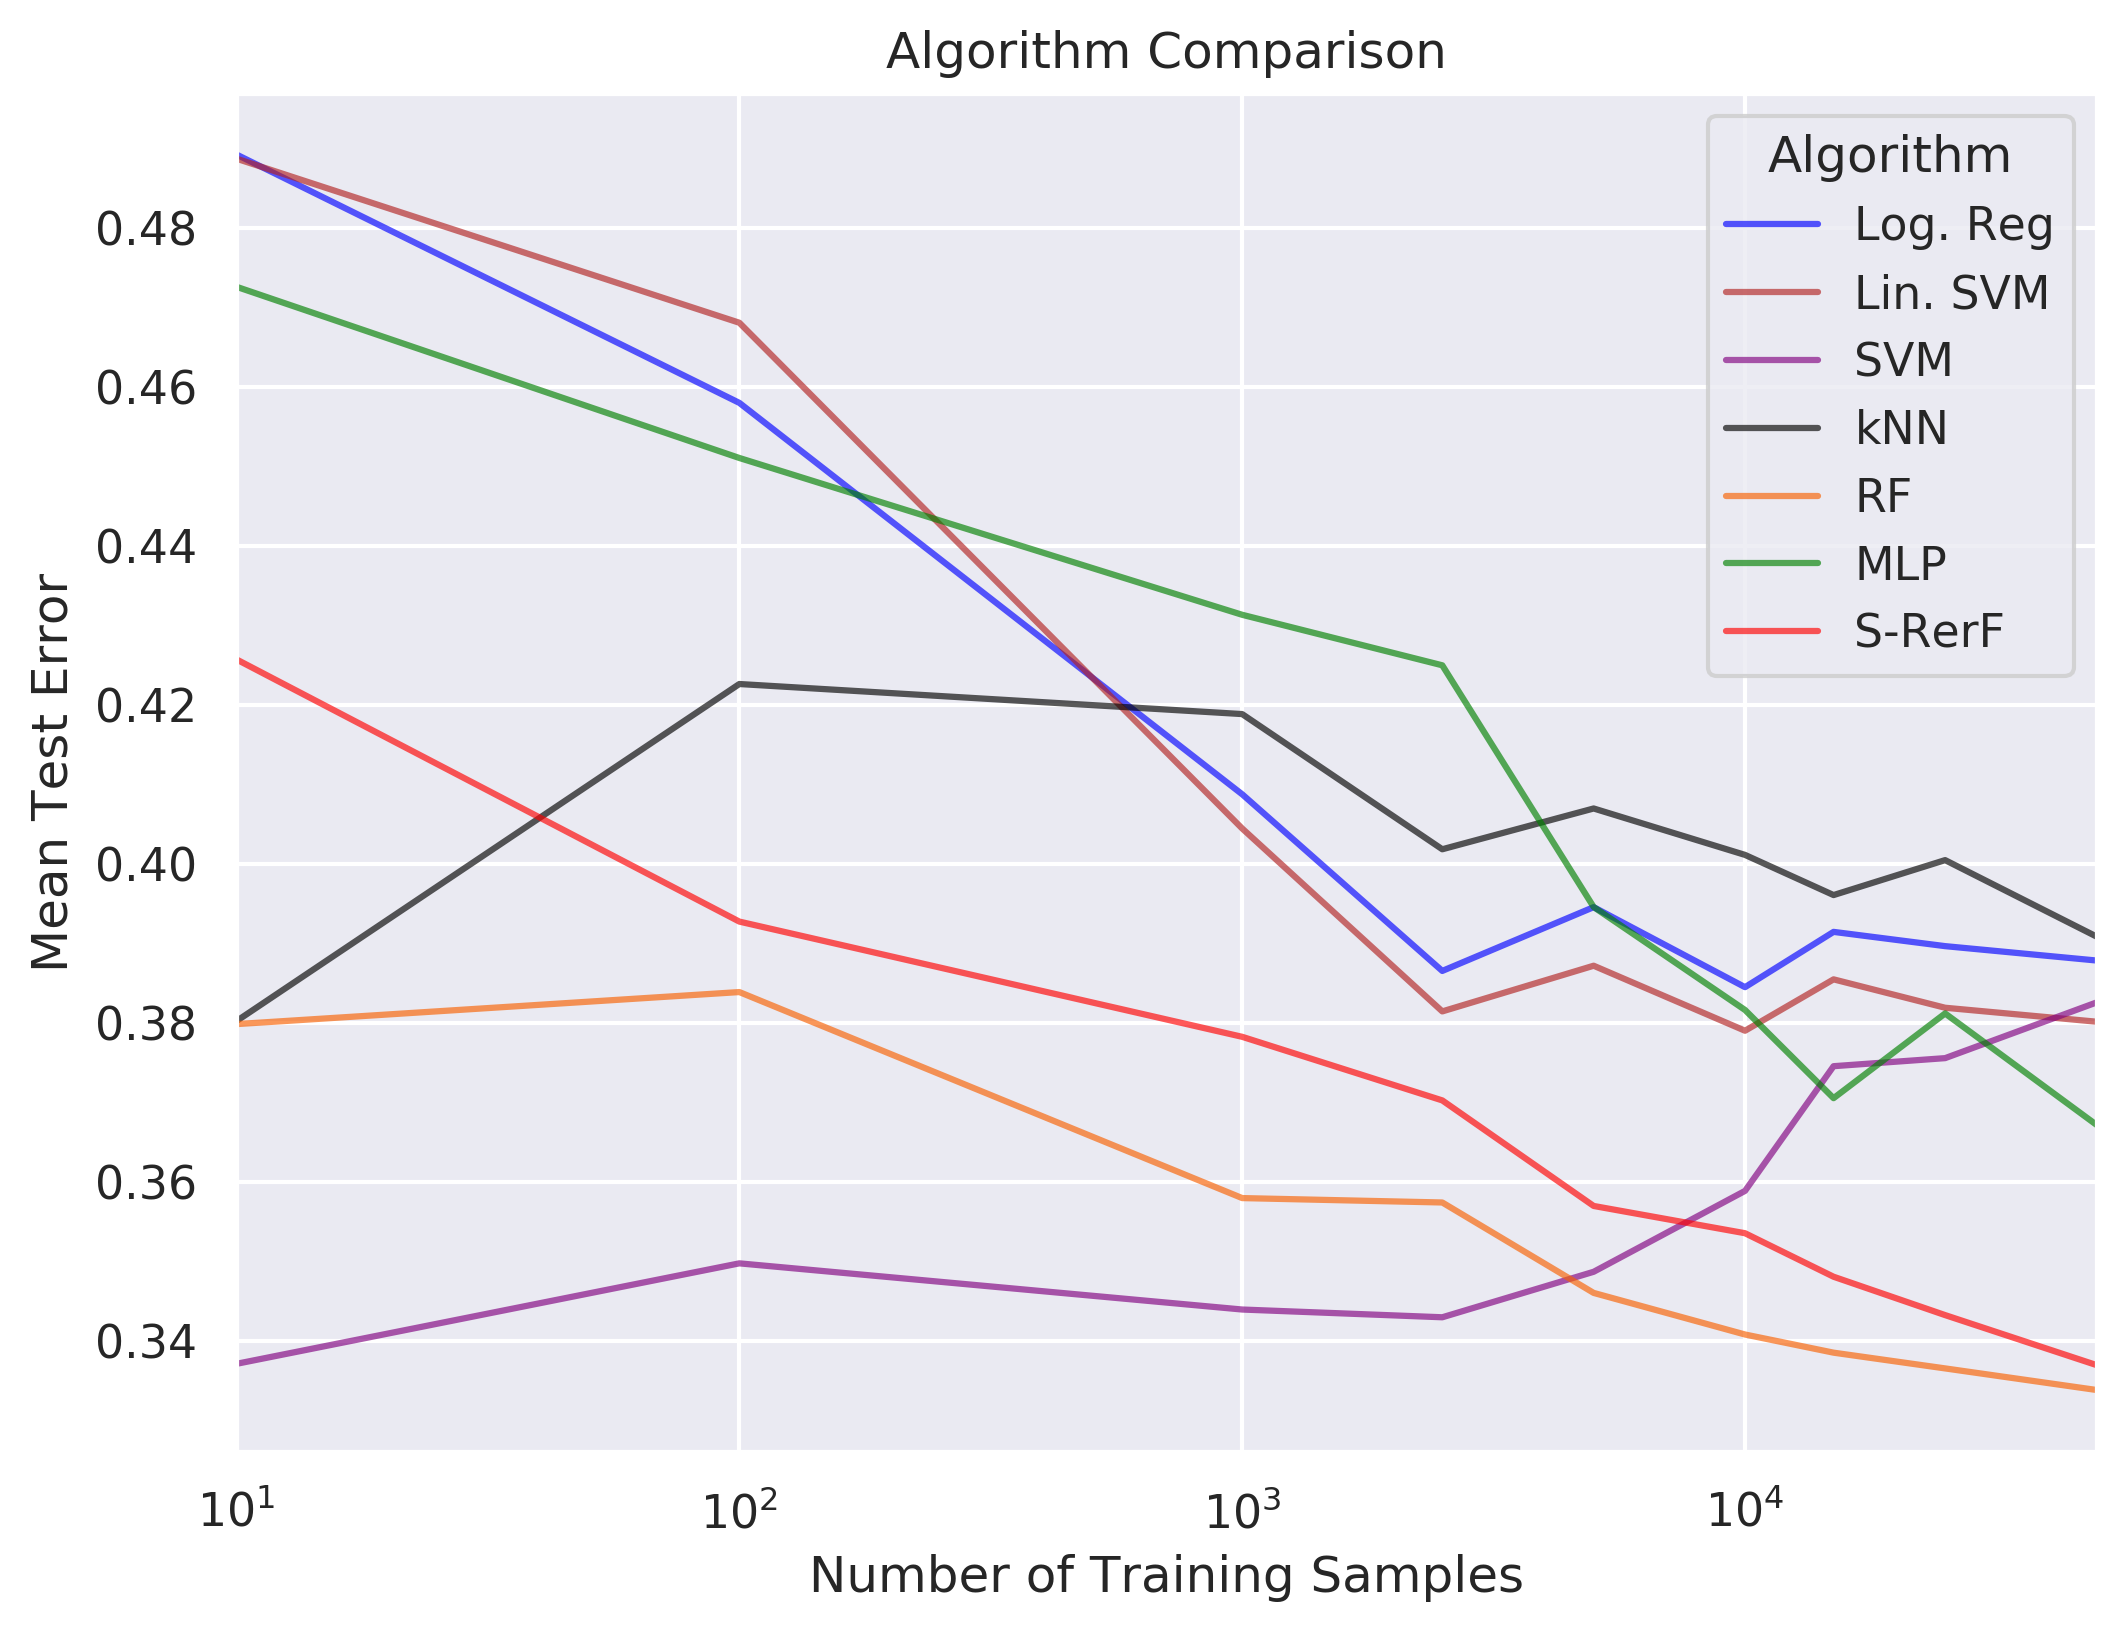

In [16]:
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
          "kNN": "black", "RF":"#f86000", "MLP":"green", "S-RerF":"red"}

## Read output file log and plot mean test error
dat = pd.read_csv("eeg_grasp_pre_lhat_3.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]
        #print(tmp)
        se = stats.sem(tmp['Lhat'].astype(float))
        #print(tmp['Lhat'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    ax.set_xscale('log')

plt.legend(loc='upper right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_circle_experiment.pdf',dpi=300,format='pdf')
plt.show()

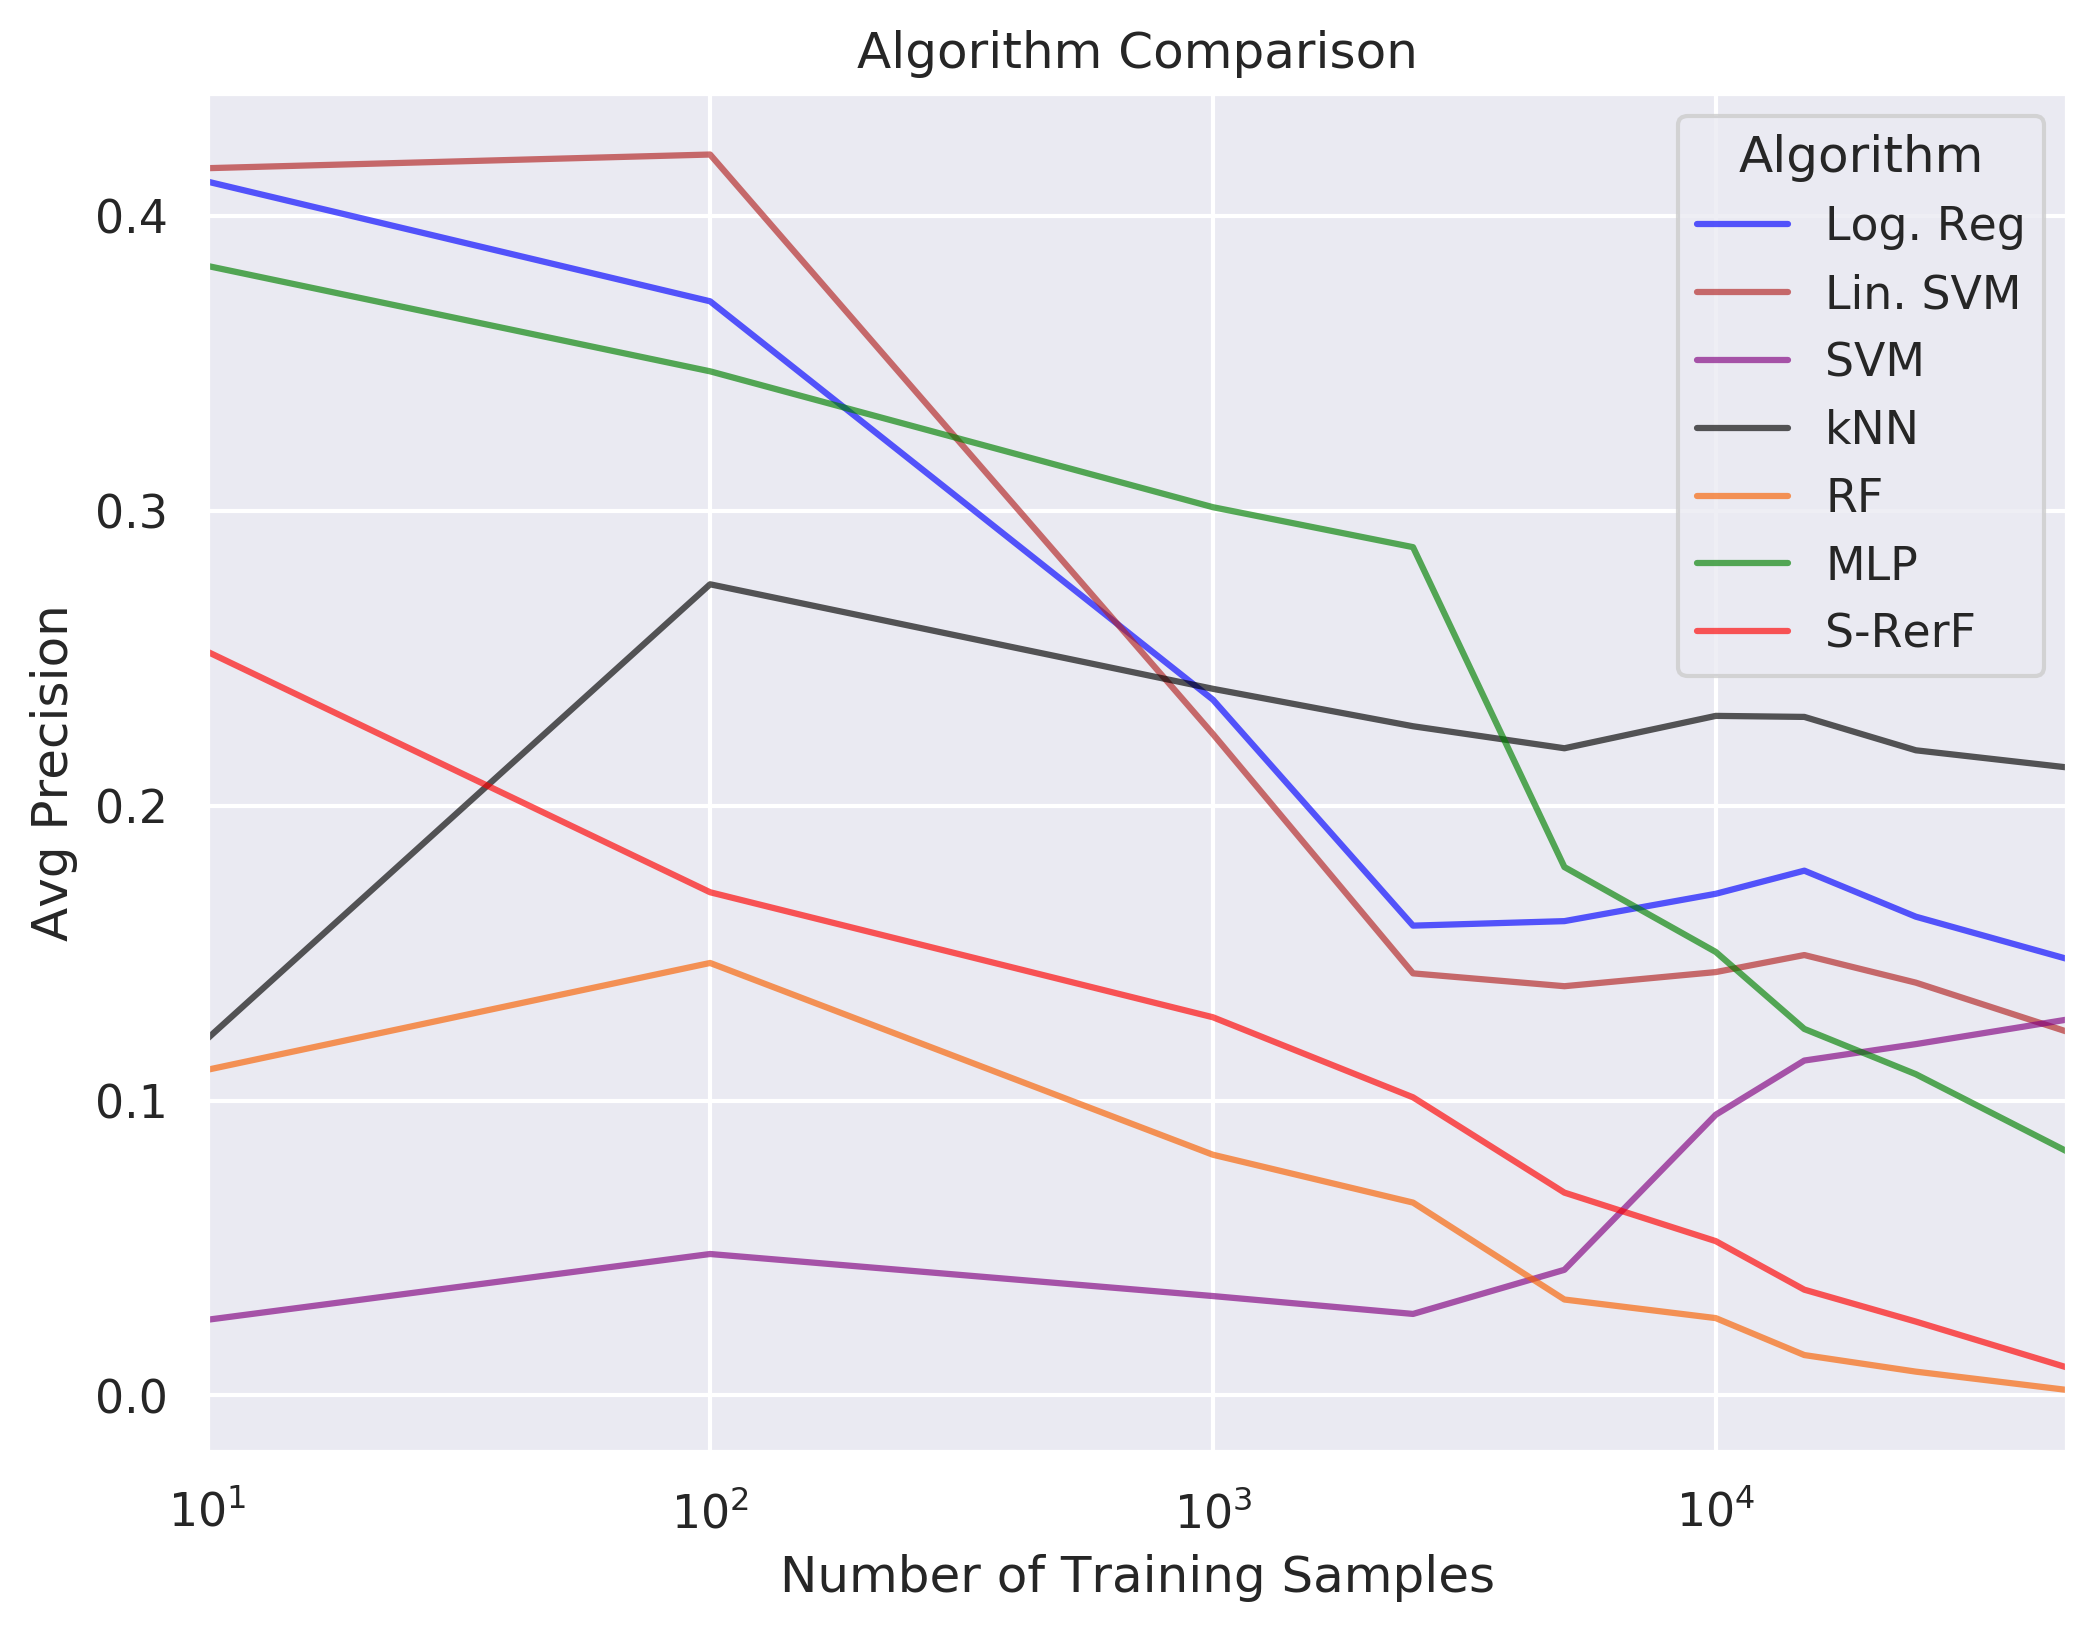

In [17]:
## Read output file log and plot average precision
dat = pd.read_csv("eeg_grasp_pre_lhat_3.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Precision', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Precision']]
        #print(tmp)
        se = stats.sem(tmp['Precision'].astype(float))
        #print(tmp['Precision'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Precision', label=key, \
            c = names[key], alpha =0.65)
    ax.set_xscale('log')

plt.legend(loc='Upper right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Avg Precision')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_circle_experiment.pdf',dpi=300,format='pdf')
plt.show()